# MuseGAN Training

## imports

In [1]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types

from models.MuseGAN import MuseGAN
from utils.loaders import load_music


from music21 import midi
from music21 import note, stream, duration



Using TensorFlow backend.


In [3]:
# run params
SECTION = 'compose'
RUN_ID = '0017'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])



if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'samples'))

mode =  'build' # ' 'load' # 

## data

In [4]:
BATCH_SIZE = 256
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
data_binary = np.squeeze(data_binary)

## architecture

In [5]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:                 
    gan.load_weights(RUN_FOLDER)

In [6]:
gan.chords_tempNetwork.summary()

Model: "temporal_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
temporal_input (InputLayer)  (None, 32)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 2, 1, 1024)        66560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1, 1024)        4096      
_________________________________________________________________
activation_1 (Activation)    (None, 2, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 2, 1, 32)          32800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 1, 32)     

In [7]:
gan.barGen[0].summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bar_generator_input (InputLa (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_11 (Activation)   (None, 1024)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 2, 1, 512)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 4, 1, 512)         524800    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 1, 512)         2048

In [8]:
gan.generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       (None, 4, 32)        0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       (None, 32)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 32)           0           melody_input[0][0]               
___________________________________________________________________________________________

In [9]:
gan.critic.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 2, 16, 84, 4)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 16, 84, 128)    1152      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 16, 84, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 16, 84, 128)    16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 16, 84, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 16, 7, 128)     196736    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1, 16, 7, 128)     0   

## training

In [10]:
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 10

gan.epoch = 0

In [11]:
gan.train(data_binary, batch_size = BATCH_SIZE, epochs = EPOCHS, run_folder = RUN_FOLDER, print_every_n_batches = PRINT_EVERY_N_BATCHES)

/home/cataluna84/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/cataluna84/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 (5, 1) [D loss: (9.5)(R -0.4, F -0.0, G 1.0)] [G loss: 0.1]


/home/cataluna84/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 (5, 1) [D loss: (-200.4)(R -263.7, F 36.0, G 2.7)] [G loss: -32.4]
2 (5, 1) [D loss: (-234.6)(R -435.9, F 100.1, G 10.1)] [G loss: -116.5]
3 (5, 1) [D loss: (-183.8)(R -343.5, F 27.7, G 13.2)] [G loss: 72.7]
4 (5, 1) [D loss: (-134.7)(R -267.0, F 40.8, G 9.2)] [G loss: 421.7]
5 (5, 1) [D loss: (-58.5)(R 8.9, F -68.2, G 0.1)] [G loss: -141.2]
6 (5, 1) [D loss: (-67.4)(R -413.3, F 323.3, G 2.3)] [G loss: -330.3]
7 (5, 1) [D loss: (-42.3)(R -373.3, F 314.1, G 1.7)] [G loss: -316.8]
8 (5, 1) [D loss: (-23.5)(R -277.4, F 248.2, G 0.6)] [G loss: -268.9]
9 (5, 1) [D loss: (-8.6)(R -174.6, F 165.8, G 0.0)] [G loss: -189.7]
10 (5, 1) [D loss: (-2.6)(R -137.0, F 134.4, G 0.0)] [G loss: -137.9]
11 (5, 1) [D loss: (3.4)(R -79.8, F 81.4, G 0.2)] [G loss: -86.0]
12 (5, 1) [D loss: (-3.3)(R -101.8, F 98.5, G 0.0)] [G loss: -111.2]
13 (5, 1) [D loss: (-13.9)(R -134.8, F 117.6, G 0.3)] [G loss: -144.4]
14 (5, 1) [D loss: (-37.8)(R -195.3, F 146.7, G 1.1)] [G loss: -160.0]
15 (5, 1) [D loss: (-15.1)(R

#######

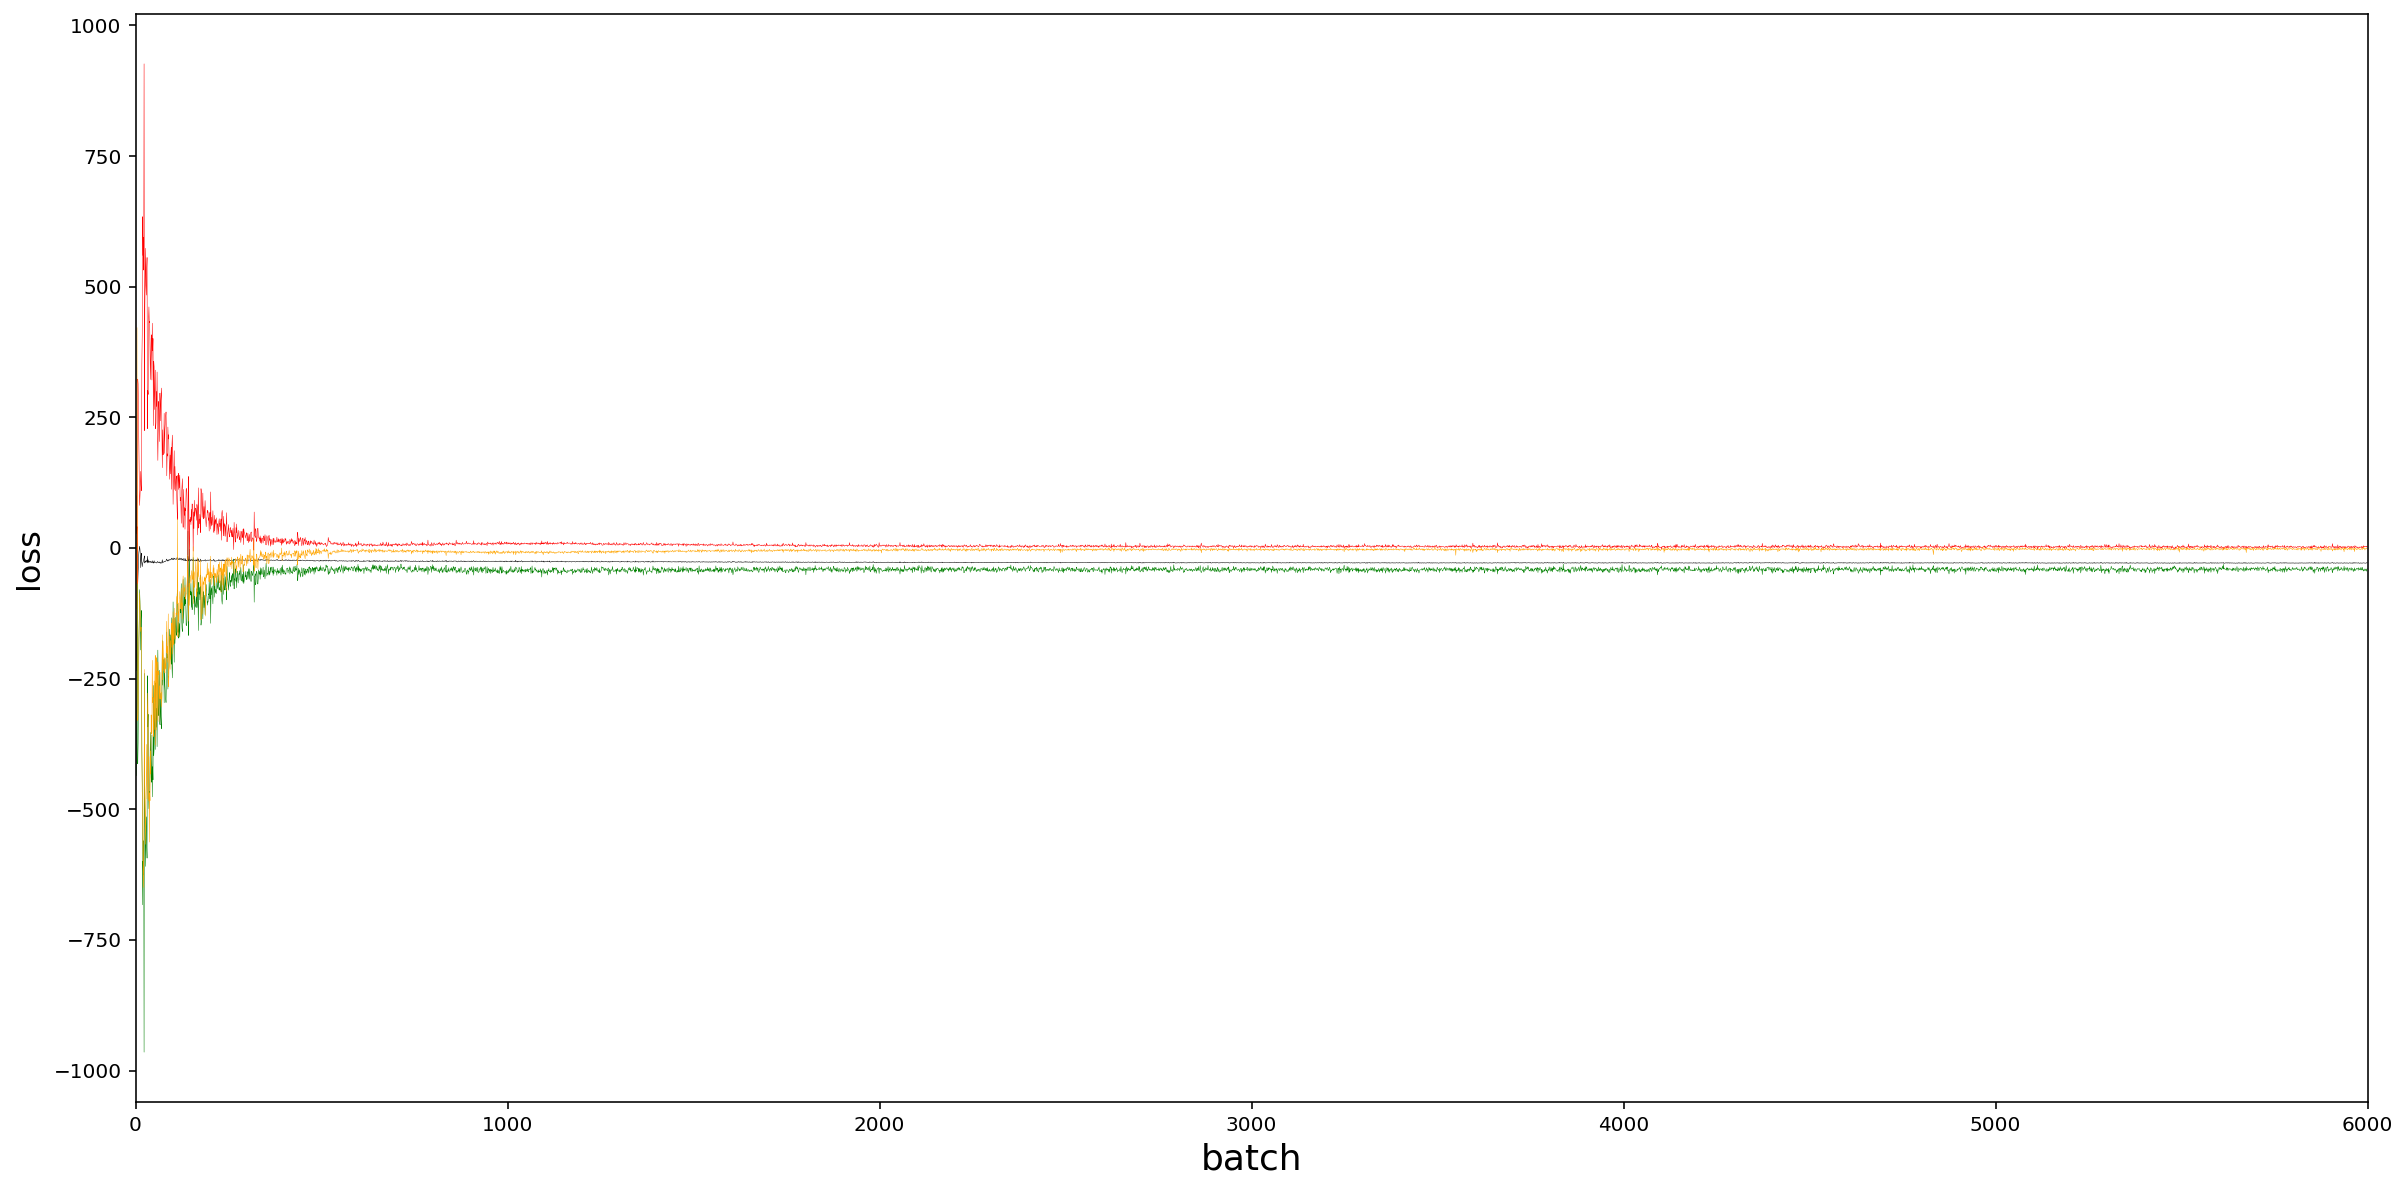

In [13]:
from IPython.core.pylabtools import figsize

figsize(20, 10)

fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, len(gan.d_losses))
# plt.ylim(0, 2)

plt.show()
